In [1]:
import pandas as pd
import numpy as np
import re
from functools import reduce
import seaborn as sns
from matplotlib import pyplot as plt
from lower_case_dict import d_dict as D_dict
from lower_case_dict import D_ocupaciones
from lower_case_dict import d_describe as D_describe
from traduce import leyenda as tr_leyenda
pd.options.display.max_columns=None
pd.options.display.max_colwidth=310
pd.options.mode.chained_assignment=None

In [2]:
# Dataset completo procesado
ruta='data/formacion_procesado.csv'
df=pd.read_csv(ruta,index_col=0,low_memory=False)

# Naive decision tree

**Clasificador de ocupaciones a partir de títulos al estilo de un arbol de decisión**, con la diferencia de que, en lugar de identificar el punto de corte más explicativo en cada etapa, este clasificador solo reparte en ramas una vez y crea **tantas ramas como títulos distintos** haya en el dataset.   

Para cada título identifica todas las ocupaciones, las ordena de más a menos frecuentes y  selecciona como predicción las ocupaciones en el **top n del ranking de frecuencias** que, además, estén por encima de un **umbral de frecuencia relativa establecido como mínimo**.   

Para cada título, este clasificador devuelve como **predicción una lista de ocupaciones ordenadas** de más a menos probables.   

Los **parámetros de este modelo** son el número n de posiciones en el ranking que se seleccionan como predictores y el umbral de frecuencia mínima.   

El número de ocupaciones en la predicción para cada título puede ser mayor o menor que  n, el número de posiciones en el ranking de frecuencias que se tienen en cuenta:   

- Si alguna ocupación en el top n del ranking tiene una frecuencia inferior al umbral, se descarta como predictor. Así, es posible que la lista de ocupaciones seleccionadas tenga menos de n elementos.  

- Cuando hay empates entre ocupaciones en el top n de frecuencias, se incluyen en la predicción todas las que pertenecen al grupo empatado. Esto hace posible que se seleccionen más de n ocupaciones como predicción. 

El funcionamiento del algoritmo se ha ilustrado empleando las columnas de título y de ocupacion literales en lugar de las nuḿericas. Se ha decidido así porque facilita el hacerse una idea de cuáles son las titulaciones para las que es más o menos probable hacer predicciones acertadas durante el proceso de construcción del clasificador. No obstante, el diseño del algoritmo permite sutituir las columnas literales por las numéricas para operar de forma más eficiente. También permite establecer otros regresores y targets. 


## Objetivo

El objetivo de la construcción de un clasificador elemental es conocer en qué medida las titulaciones universitarias explican por sí solas las profesiones que alcanzan los titulados.   
Se espera un éxito modesto por varios motivos:   

- Los títulos universitarios no son el único critero de los empleadores para seleccionar a su plantilla. Por un lado, un título universitario suele ser insuficiente por sí solo para aspirar a un buen número de puestos de trabajo reservados a universitarios. Por otro lado, a menudo los candidatos a un empleo pueden suplir la falta de un título universitario especializado a menudo con otros méritos, como la experiencia profesional o la formación en disciplinas afines. Los estudios de medicina son una excepción clara a esta posibilidad; los resultados constatan que las profesiones sanitarias están reservadas a titulados con formación especializada (aunque no todos los que tienen esa formación trabajan en ocupaciones relacionadas con su título). 

- Las encuestas empleadas en este proyecto solo informan con detalle de un título universitario de cada encuestado. Aquellos que han accedido a su profesión gracias a un título distinto del que les hace elegibles para la encuesta en la que participan (otro grado, otro máster, un título de doctor) se escapan a la capacidad predictiva de los modelos basados en estos datos.  Esto se notará especialmente en los casos en los que el encuestado responde sobre un título que ha estudiado por motivos distintos a búsqueda de empleo o la promoción profesional mientras trabajaban en ocupaciones a las que accedieron gracias a una titulación previa.  

- El mal funcionamiento del mercado de trabajo español empuja a muchos aspirantes a un empleo a aceptar trabajos poco o nada relacionados con su formación y sus conocimientos.   


## Justificación
**Ventajas de la construcción del algoritmo a medida** (en lugar de emplear una solución estándar):  
- **Simplicidad** de la justificación teórica que sustenta las predicciones. Facilita la interpretación de los resultados.  

- Clasificador **específico** para el caso en el que **el regresor y el target son variables categóricas**.  
  
- El proceso de construcción del algoritmo es, en su mayor parte, un **análisis descriptivo** de las relaciones entre titulaciones y ocupaciones. Este análisis se ha ilustrado y probado con los datos de la encuesta completa para estimar la dificultad del problema de clasificación (que se resuelve, más adelante, sobre subconjuntos de train, validación y test).  
  
- **Flexibilidad** para definir los criterios de agregación de las métricas de evaluación, por titulaciones o por ocupaciones. Facilita la identificación de los títulos y las profesiones para las que es más y menos probable hacer predicciones acertadas. 

# Dataset encuesta y dataset filtrado por 'utilidad'

#### Observaciones con target informado

In [3]:
# Selección: solo ocupaciones informadas
df=df[df['ocupacion'].notna()]
df.shape

(59844, 311)

#### Número de categorías distintas del target: 

In [4]:
df['ocupacion'].nunique()
# Ocupaciones distintas (núm. categorías del target):

62

#### Número de categorías distintas del regresor: 

In [5]:
df['titulo_ppal_'].nunique()
# Titulos distintos (num. categorías del regresor principal): 

173

### Filtro  por utilidad: 
Solo encuestados que declaran que el título les ha sido útil para encontrar trabajo.   
Se pierden unas 30000 observaciones. El dataset reducido conserva todas las ocupaciones y todos los titulos presentes en la encuesta. 

In [6]:
dfr=df[df['utilidad']==1]
dfr.shape[0]

41283

In [7]:
dfr['ocupacion'].nunique()

62

In [8]:
dfr['titulo_ppal_'].nunique()

173

# Número de ocupaciones distintas por título

### Regresor y target:
En adelante se identifican el título principal como regresor y la ocupación como target. Esto facilitará la generalización del clasificador naive a otros targets y regresores. 

In [9]:
def num_cat_targets_por_cat_regresor(data,regresor,target):
    columnas=[regresor,target]
    out=data[columnas].groupby(regresor).agg(['nunique'])
    out.columns=out.columns.to_flat_index() 
    out.rename(columns={out.columns[-1]:'num categorias target por regresor'},inplace=True)
    out.sort_values(by='num categorias target por regresor',inplace=True)
    out.reset_index(inplace=True)
    
    return out

In [10]:
num_oc_por_titulo_encuesta=num_cat_targets_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
num_oc_por_titulo_encuesta.head(10)

,titulo_ppal_,num categorias target por regresor
0,Grado Odontología,5
1,Máster Odontología,6
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",8
3,Máster Religión y teología,9
4,Máster Lenguas (Otros estudios),10
5,Grado Medicina,10
6,Máster Veterinaria,10
7,Grado Protocolo y eventos,11
8,Máster Estadística,11
9,Máster Enfermería,11


In [11]:
num_oc_por_titulo_encuesta.tail(10)

,titulo_ppal_,num categorias target por regresor
163,"Grado Ingeniería agrícola, agropecuaria y medio rural",50
164,Grado Actividad física y del deporte,50
165,Grado Trabajo social,51
166,Grado Educación infantil,52
167,Grado Ciencias ambientales,52
168,Grado Educación primaria,52
169,Grado Economía,53
170,Grado Historia,53
171,Grado Arquitectura técnica,53
172,Grado Administración y empresa,54


###### (*) La distribución del número de ocupaciones por título es igual en el dataset original y en el reducido con el filtro de 'utilidad':

In [12]:
num_oc_por_titulo_filtro=num_cat_targets_por_cat_regresor(dfr,regresor='titulo_ppal_',target='ocupacion_')
#num_oc_por_titulo_filtro

In [13]:
oc_por_titulo=pd.DataFrame({'encuesta':num_oc_por_titulo_encuesta['num categorias target por regresor'],
                     'filtro':num_oc_por_titulo_filtro['num categorias target por regresor']})
oc_por_titulo['encuesta'].equals(oc_por_titulo['filtro'])

False

[Text(0.5, 1.0, 'Distribución del número de ocupaciones por título'),
 Text(0.5, 0, 'Número de ocupaciones por título')]

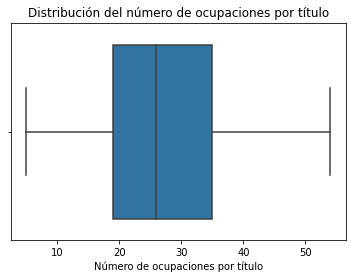

In [14]:
ax=sns.boxplot(data=num_oc_por_titulo_encuesta,x='num categorias target por regresor')
ax.set(title='Distribución del número de ocupaciones por título',xlabel='Número de ocupaciones por título')

Text(0, 0.5, 'Frecuencia')

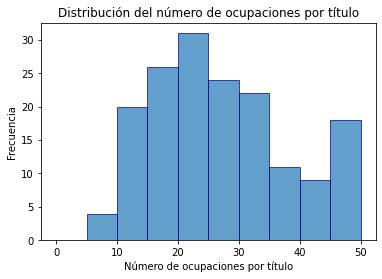

In [15]:
plt.hist(num_oc_por_titulo_encuesta['num categorias target por regresor'],bins=np.arange(0,55,5),\
         color='tab:blue',alpha=0.7,edgecolor='darkblue',linewidth=1)
plt.title('Distribución del número de ocupaciones por título')
plt.xlabel('Número de ocupaciones por título')
plt.ylabel('Frecuencia')

## Número de ocupaciones distintas por título: resumen 

In [16]:
num_oc_por_titulo_encuesta['num categorias target por regresor'].describe()

count    173.000000
mean      27.705202
std       12.290563
min        5.000000
25%       19.000000
50%       26.000000
75%       35.000000
max       54.000000
Name: num categorias target por regresor, dtype: float64

# Número de ocupaciones distintas por rama de conocimento

In [17]:
# df auxiliar para añadir ramas de conocimiento a la distribución de número de ocupaciones por título
df_ramas=df[['titulo_ppal_','rama_ppal_']].drop_duplicates()
df_ramas.head()

,titulo_ppal_,rama_ppal_
0,Grado Pedagogía,Ciencias sociales y jurídicas
398,Grado Pedagogía,Artes y humanidades
568,Grado Educación infantil,Ciencias sociales y jurídicas
1933,Grado Educación primaria,Ciencias sociales y jurídicas
3840,Grado Otros maestros,Ciencias sociales y jurídicas


In [18]:
num_oc_por_titulo_ramas=num_oc_por_titulo_encuesta.merge(df_ramas,on='titulo_ppal_',how='left')
num_oc_por_titulo_ramas.head()

,titulo_ppal_,num categorias target por regresor,rama_ppal_
0,Grado Odontología,5,Ciencias de la salud
1,Máster Odontología,6,Ciencias de la salud
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",8,Ciencias
3,Máster Religión y teología,9,Artes y humanidades
4,Máster Lenguas (Otros estudios),10,Artes y humanidades


[Text(0, 0, 'Ciencias de la salud'),
 Text(1, 0, 'Ciencias'),
 Text(2, 0, 'Artes y humanidades'),
 Text(3, 0, 'Ingeniería y arquitectura'),
 Text(4, 0, 'Ciencias sociales y jurídicas')]

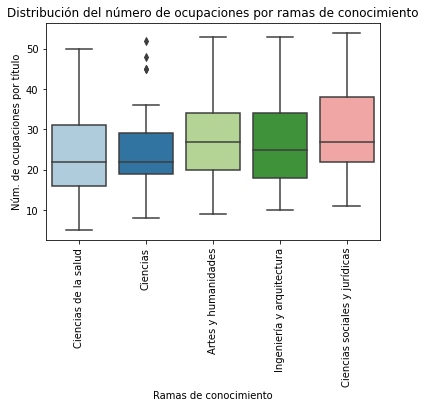

In [19]:
ax = sns.boxplot(data=num_oc_por_titulo_ramas, x='rama_ppal_',\
                                               y='num categorias target por regresor', palette='Paired')
ax.set(title='Distribución del número de ocupaciones por ramas de conocimiento',xlabel='Ramas de conocimiento',
       ylabel='Núm. de ocupaciones por título')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [20]:
df['ambito_g1_'].unique()

array(['Educación (Otros estudios) ',
       'Formación de docentes de enseñanza infantil ',
       'Formación de docentes de enseñanza primaria ',
       'Técnicas audiovisuales y medios de comunicación ',
       'Artes (Otros estudios) ', 'Humanidades ', 'Lenguas ', 'Economía ',
       'Ciencias sociales y del comportamiento (Otros estudios) ',
       'Psicología ', 'Periodismo y documentación ',
       'Negocios y administración (Otros estudios) ',
       'Dirección y administración ', 'Derecho ', 'Ciencias de la vida ',
       'Medio ambiente ', 'Ciencias químicas, físicas y geológicas ',
       'Matemáticas y estadística ', 'Informática',
       'Ingeniería y profesiones afines ',
       'Industria manufacturera y producción ',
       'Arquitectura y construcción ', 'Agricultura y ganadería ',
       'Silvicultura ', 'Veterinaria ', 'Salud (Otros estudios) ',
       'Medicina ', 'Enfermería ', 'Servicios sociales ',
       'Actividades físicas y deportivas ', 'Viajes, turismo y oc

In [21]:
df['ambito_m1_'].unique()

array([nan, 'SALUD Y SERVICIOS SOCIALES', 'EDUCACIÓN', 'INFORMÁTICA',
       'CIENCIAS', 'INGENIERÍA, INDUSTRIA Y CONSTRUCCIÓN',
       'NEGOCIOS, ADMINISTRACIÓN Y DERECHO', 'SERVICIOS',
       'CIENCIAS SOCIALES, PERIODISMO Y DOCUMENTACIÓN',
       'ARTES Y HUMANIDADES',
       'AGRICULTURA, GANADERÍA, SILVICULTURA, PESCA Y VETERINARIA'],
      dtype=object)

## Número de titulados por título: 

In [22]:
def num_obs_por_cat_regresor(data,regresor,target):
    
    columnas=[regresor,target]
    out=data[columnas].groupby([regresor]).agg(['count'])
    out.columns=out.columns.to_flat_index()
    out.reset_index(inplace=True)
    out.rename(columns={out.columns[-1]:'obs regresor'},inplace=True)
    
    previo=num_cat_targets_por_cat_regresor(data=data,regresor=regresor,target=target)
    out=out.merge(previo,on=regresor,how='outer')
    out=out.sort_values(by='num categorias target por regresor')
    out.reset_index(drop=True,inplace=True)
    
    return out

In [23]:
num_titulados_encuesta=num_obs_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
num_titulados_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target por regresor
0,Grado Odontología,243,5
1,Máster Odontología,73,6
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8
3,Máster Religión y teología,25,9
4,Máster Lenguas (Otros estudios),53,10


In [24]:
num_titulados_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target por regresor
168,Grado Educación primaria,2065,52
169,Grado Economía,1174,53
170,Grado Historia,697,53
171,Grado Arquitectura técnica,1050,53
172,Grado Administración y empresa,2637,54


## Número de profesionales por título y ocupación: 

In [25]:
def num_cat_target_por_regresor_y_target(data,regresor,target):
    
    columnas=[regresor,target]
    out=data[columnas].groupby(regresor).agg(['value_counts'])
    out.columns=out.columns.to_flat_index()
    out.reset_index(inplace=True)
    out.rename(columns={out.columns[-1]:'obs target'},inplace=True)
    
    previo=num_obs_por_cat_regresor(data=data,regresor=regresor,target=target)
    out=previo.merge(out,on=regresor,how='outer')
    out.sort_values(by=['num categorias target por regresor','obs target'],ascending=[True,False],inplace=True)
    
    return out

In [26]:
prof_por_oc_y_titulo_encuesta=num_cat_target_por_regresor_y_target(data=df,
                                                                   regresor='titulo_ppal_',target='ocupacion_')
prof_por_oc_y_titulo_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target por regresor,ocupacion_,obs target
0,Grado Odontología,243,5,Prof sanitarios,237
1,Grado Odontología,243,5,Gerentes em servicios excepto hostelería y comercio,2
2,Grado Odontología,243,5,Prof enseñanza,2
3,Grado Odontología,243,5,Directores producción y operaciones,1
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1


In [27]:
prof_por_oc_y_titulo_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target por regresor,ocupacion_,obs target
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1


## Proporción de profesionales sobre titulados por ocupación y título
Frecuencias relativas y frecuencias relativas acumuadas de las ocupaciones para cada título.   
(*) Para calcular las frecuencias acumuladas se ordenan las ocupaciones por frecuencia relativa en orden descendente. 

In [28]:
def frecuencias_cat_target_por_regresor(data,regresor,target):
    
    previo=num_cat_target_por_regresor_y_target(data=data,regresor=regresor,target=target)
    # 'prop' = proporción de obs. del target sobre núm. obs. para la categoría del regresor: 
    previo['prop']=previo['obs target'].div(previo['obs regresor'])
    
    # Frecuencias acumuladas: 
    acum=previo[[regresor,'prop']].groupby(regresor).cumsum()
    acum.rename(columns={acum.columns[-1]:'prop acum'},inplace=True)
    
    out=previo.merge(acum,left_index=True,right_index=True,how='outer')
    
    
    return out

In [29]:
proporciones_encuesta=frecuencias_cat_target_por_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
proporciones_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target por regresor,ocupacion_,obs target,prop,prop acum
0,Grado Odontología,243,5,Prof sanitarios,237,0.975309,0.975309
1,Grado Odontología,243,5,Gerentes em servicios excepto hostelería y comercio,2,0.008230,0.983539
2,Grado Odontología,243,5,Prof enseñanza,2,0.008230,0.991770
3,Grado Odontología,243,5,Directores producción y operaciones,1,0.004115,0.995885
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1,0.004115,1.000000


In [30]:
proporciones_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target por regresor,ocupacion_,obs target,prop,prop acum
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1,0.000379,0.998483
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1,0.000379,0.998862
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1,0.000379,0.999242
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1,0.000379,0.999621
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1,0.000379,1.000000


## Ranking de ocupaciones por título: 

In [31]:
def ranking_cat_target_por_cat_regresor(data,regresor,target):
    
    previo=frecuencias_cat_target_por_regresor(data=data,regresor=regresor,target=target)
    rank=previo[[regresor,'obs target']]
    rank=rank.groupby(regresor).rank(method='min',ascending=False)
    rank.rename(columns={rank.columns[-1]:'rank'},inplace=True)
    
    out=previo.merge(rank,how='outer',left_index=True,right_index=True)
    out.sort_values(by=['num categorias target por regresor','rank'],inplace=True)
    
    return out 

In [32]:
ranking_encuesta=ranking_cat_target_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
ranking_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target por regresor,ocupacion_,obs target,prop,prop acum,rank
0,Grado Odontología,243,5,Prof sanitarios,237,0.975309,0.975309,1.0
1,Grado Odontología,243,5,Gerentes em servicios excepto hostelería y comercio,2,0.008230,0.983539,2.0
2,Grado Odontología,243,5,Prof enseñanza,2,0.008230,0.991770,2.0
3,Grado Odontología,243,5,Directores producción y operaciones,1,0.004115,0.995885,4.0
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1,0.004115,1.000000,4.0


In [33]:
ranking_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target por regresor,ocupacion_,obs target,prop,prop acum,rank
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1,0.000379,0.998483,48.0
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1,0.000379,0.998862,48.0
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1,0.000379,0.999242,48.0
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1,0.000379,0.999621,48.0
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1,0.000379,1.000000,48.0


# Ranking de ocupaciones más frecuentes por título (clasificador naive) 

Equivalente al proceso de entrenamiento.

In [34]:
def naive_fit(data,regresor,target,max_rank,min_prop):
    
    previo=ranking_cat_target_por_cat_regresor(data=data,regresor=regresor,target=target)
    
    naive=previo[previo['rank']<=max_rank]
    naive=naive[naive['prop']>=min_prop]
    
    naive.sort_values(by=['num categorias target por regresor',regresor,'rank'],inplace=True)
    naive.reset_index(drop=True,inplace=True)
    naive.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)
    
    return naive

In [35]:
naive_encuesta=naive_fit(data=df,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)
naive_encuesta.sample(2)

,regresor: titulo_ppal_,obs regresor,num categorias target por regresor,target: ocupacion_,obs target,prop,prop acum,rank
209,Máster Bioquímica,107,20,Técnicos ciencias e ingenierías,18,0.168224,0.457944,2.0
233,Grado Biotecnología,203,22,"Prof ciencias, matemáticas e ingeniería",95,0.467980,0.467980,1.0


In [36]:
#with pd.option_context("display.max_rows", naive_encuesta.shape[0]):
#    display(naive_encuesta)

# Entrenamiento, validación y test
Se separan los dataset de train, validación y test sin distinguir regresores y target porque es más conveniente mantener todas las columnas en un dataframe único para aplicar el algoritmo y evaluar los resultados. 

In [37]:
def train_vld_test(df):
    df.sample(frac=1,random_state=23) # reordenación aleatoria
    n_train=int(df.shape[0]*0.6)
    n_vld=int(df.shape[0]*0.8)
    df_train=df[:n_train]
    df_vld=df[n_train:n_vld]
    df_test=df[n_vld:]
    
    return df_train, df_vld, df_test

#### Dataset original: 

In [38]:
df_train, df_vld, df_test =train_vld_test(df)
df_train.shape[0]+df_vld.shape[0]+df_test.shape[0]==df.shape[0] # Comprobación

True

#### Dataset reducido (filtro 'utilidad'): 

In [39]:
dfr_train, dfr_vld, dfr_test =train_vld_test(dfr)

# Predicciones 

In [40]:
def naive_prediccion(clasificador,valor_regresor):
    
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0]
    
    modelo=clasificador[clasificador[regresor]==valor_regresor]
    prd=modelo[[target,'prop']]
    prd.reset_index(drop=True,inplace=True)
    prd.rename(columns={target:'prediccion','prop':'probabilidad'},inplace=True)
    
    return prd

In [41]:
# Fit en train:
naive_5_05_train=naive_fit(data=df_train,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)
naive_5_05_train.head()  

,regresor: titulo_ppal_,obs regresor,num categorias target por regresor,target: ocupacion_,obs target,prop,prop acum,rank
0,Grado Odontología,125,4,Prof sanitarios,120,0.960000,0.960000,1.0
1,Máster Odontología,60,5,Prof sanitarios,54,0.900000,0.900000,1.0
2,Máster Odontología,60,5,Prof enseñanza,3,0.050000,0.950000,2.0
3,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",29,8,Prof enseñanza,12,0.413793,0.413793,1.0
4,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",29,8,"Prof ciencias, matemáticas e ingeniería",4,0.137931,0.551724,2.0


In [42]:
naive_5_05_train.tail()

,regresor: titulo_ppal_,obs regresor,num categorias target por regresor,target: ocupacion_,obs target,prop,prop acum,rank
693,Grado Administración y empresa,1757,52,"Expertos en gestión, finanzas, comercio, etc",344,0.195788,0.195788,1.0
694,Grado Administración y empresa,1757,52,"Empleados servicios financieros, contables y de apoyo",246,0.140011,0.335800,2.0
695,Grado Administración y empresa,1757,52,Empleados administrativos sin atención al público,218,0.124075,0.459875,3.0
696,Grado Administración y empresa,1757,52,Representantes e intermediarios,113,0.064314,0.524189,4.0
697,Grado Administración y empresa,1757,52,Prof derecho,97,0.055208,0.579397,5.0


In [43]:
# Inspección: 
naive_prediccion(clasificador=naive_5_05_train,valor_regresor='Máster Odontología')

,prediccion,probabilidad
0,Prof sanitarios,0.90
1,Prof enseñanza,0.05


In [44]:
# Inspección: 
naive_prediccion(naive_5_05_train,valor_regresor='Grado Economía')

,prediccion,probabilidad
0,"Expertos en gestión, finanzas, comercio, etc",0.182504
1,"Empleados servicios financieros, contables y de apoyo",0.138763
2,Empleados administrativos sin atención al público,0.096531
3,Otros empleados administrativos con atención al público,0.067873
4,Representantes e intermediarios,0.063348


In [45]:
# Inspección: 
naive_prediccion(naive_5_05_train,valor_regresor='Grado Matemáticas')

,prediccion,probabilidad
0,Prof enseñanza,0.394040
1,Profesionales IT,0.145695
2,"Prof ciencias, matemáticas e ingeniería",0.119205
3,Técnicos TI,0.096026
4,"Expertos en gestión, finanzas, comercio, etc",0.072848


# Evaluación del clasificador

In [46]:
def naive_evalua(clasificador, data):
    
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0].split(' ')[1]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0].split(' ')[1]
    
    evalua=data[[regresor,target]]
    
    # Columnas con predicciones (lista targets predichos y lista probabilidades)
    evalua['prediccion']=evalua[regresor]\
                         .apply(lambda valor: naive_prediccion(clasificador,valor)['prediccion'].tolist())
    evalua['prediccion probs']=evalua[regresor]\
                         .apply(lambda valor: naive_prediccion(clasificador,valor)['probabilidad'].tolist())
    
    # Núm predicciones:
    evalua['num pred']=evalua['prediccion'].apply(lambda lista:len(lista))
    max_rank=evalua['num pred'].max()
    
    # Columnas con probabilidades de predicciones (una columna por prob.): 
    #for i in range(max_rank):
    #    prueba['p'+str(i)]=prueba['prediccion probs'][prueba['num pred']>=i+1].apply(lambda lista:lista[i])
    
    # Columna 'acierto' (binaria)
    evalua['acierto']=evalua.apply(lambda row: row[target] in row['prediccion'],axis=1).astype(int)
    
    # Posición de predicción acertada: 
    evalua['posicion acierto']=evalua[evalua['acierto']==1]\
                              .apply(lambda row: row['prediccion'].index(row[target])+1,axis=1)
    
    # Columna 'probabilidad asociada la predicción acertada' (acierto ajustado por probabilidad):
    evalua['prob pred acertada']=evalua[evalua['acierto']==1]\
                            .apply(lambda row: row['prediccion probs'][int(row['posicion acierto'])-1],axis=1)
    del evalua['prediccion probs']
    
    # Núm. de aciertos (binaria) para cada categoría del regresor: 
    aciertos_por_cat_regresor=evalua[[regresor,'acierto']].groupby(regresor).agg(['sum'])
    aciertos_por_cat_regresor.columns=aciertos_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos por cat regresor'},inplace=True)
    
    # Suma aciertos ajustados por prob para cada categoría del regresor: 
    acierto_ajustado_por_cat_regresor=evalua[[regresor,'prob pred acertada']].groupby(regresor).agg(['sum'])
    acierto_ajustado_por_cat_regresor.columns=acierto_ajustado_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(acierto_ajustado_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por cat regresor'},inplace=True)
    
    # Num. de observaciones para cada categoría del regresor:
    total_obs_por_cat_regresor=evalua[[regresor,'acierto']].groupby(regresor).agg(['count'])
    total_obs_por_cat_regresor.columns=total_obs_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num obs regresor'},inplace=True)
    
    # Accuracy y accuracy ajustado para cada categoría del regresor: 
    evalua['accuracy regresor']=evalua['aciertos por cat regresor'].div(evalua['num obs regresor'])
    evalua['accuracy ajustado regresor']=evalua['aciertos ajustados por cat regresor']\
                                        .div(evalua['num obs regresor'])
    
    total_obs=evalua.shape[0]
    
    # Accuracy y accuracy a ajustadp de cada categoría del regresor ponderados por peso categoría: 
    evalua['peso regresor']=evalua['num obs regresor']/total_obs
    evalua['accuracy ponderado regresor']=evalua['accuracy regresor']*evalua['peso regresor']
    evalua['accuracy ajustado ponderado regresor']=evalua['accuracy ajustado regresor']*evalua['peso regresor']
    
    # Núm. de aciertos (binaria) para cada categoría del target: 
    aciertos_por_cat_target=evalua[[target,'acierto']].groupby(target).agg(['sum'])
    aciertos_por_cat_target.columns=aciertos_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos por cat target'},inplace=True)
    
    # Suma aciertos ajustados por prob para cada categoría del target: 
    acierto_ajustado_por_cat_target=evalua[[target,'prob pred acertada']].groupby(target).agg(['sum'])
    acierto_ajustado_por_cat_target.columns=acierto_ajustado_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(acierto_ajustado_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por cat target'},inplace=True)
    
    # Num. de observaciones para cada categoría del target:
    total_obs_por_cat_target=evalua[[target,'acierto']].groupby(target).agg(['count'])
    total_obs_por_cat_target.columns=total_obs_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num obs target'},inplace=True)
  
    # Recall y recall ajustado para cada categoría del target:
    evalua['recall target']=evalua['aciertos por cat target'].div(evalua['num obs target'])
    evalua['recall ajustado target']=evalua['aciertos ajustados por cat target'].div(evalua['num obs target'])
    
    # Recall y recall ajustado para cada categoría del target ponderado por peso de la categoría: 
    evalua['peso target']=evalua['num obs target']/total_obs
    evalua['recall ponderado target']=evalua['recall target']*evalua['peso target']
    evalua['recall ajustado ponderado target']=evalua['recall ajustado target']*evalua['peso target']
    
    # Formato:
    evalua.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)

    return evalua

### Evaluación desagregada (en train):

In [47]:
naive_5_05_evalua_train=naive_evalua(clasificador=naive_5_05_train, data=df_train)
naive_5_05_evalua_train.sample(2)

,regresor: titulo_ppal_,target: ocupacion_,prediccion,num pred,acierto,posicion acierto,prob pred acertada,aciertos por cat regresor,aciertos ajustados por cat regresor,num obs regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,aciertos por cat target,aciertos ajustados por cat target,num obs target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
12032,Grado Trabajo social,Prof ciencias sociales,"[Prof ciencias sociales, Prof apoyo servicios jurídicos, socio-culturales, deportivos]",2,1,1.0,0.485190,382,168.942172,709,0.538787,0.238282,0.019746,0.010639,0.004705,1022,370.045212,1317,0.776006,0.280976,0.036679,0.028463,0.010306
30490,Grado Derecho,Prof derecho,"[Prof derecho, Expertos en gestión, finanzas, comercio, etc, Empleados administrativos sin atención al público, Empleados servicios financieros, contables y de apoyo]",4,1,1.0,0.391337,851,235.185213,1339,0.635549,0.175642,0.037292,0.023701,0.006550,821,284.903032,1000,0.821000,0.284903,0.027850,0.022865,0.007935


In [48]:
naive_5_05_evalua_train['acierto'].sum()/naive_5_05_evalua_train['acierto'].count()

0.6688018715535008

### Evaluación desagregada (en validación):

In [49]:
naive_5_05_evalua_vld=naive_evalua(clasificador=naive_5_05_train, data=df_vld)
naive_5_05_evalua_vld.head(2)

,regresor: titulo_ppal_,target: ocupacion_,prediccion,num pred,acierto,posicion acierto,prob pred acertada,aciertos por cat regresor,aciertos ajustados por cat regresor,num obs regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,aciertos por cat target,aciertos ajustados por cat target,num obs target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
0,Máster Bioquímica,"Prof ciencias, matemáticas e ingeniería","[Prof ciencias, matemáticas e ingeniería, Técnicos ciencias e ingenierías, Prof sanitarios, Prof enseñanza]",4,1,1.0,0.294118,2,0.441176,5,0.400000,0.088235,0.000418,0.000167,0.000037,2049,697.593024,2152,0.952138,0.32416,0.179798,0.171192,0.058283
1,Máster Electrónica y automática,"Prof ciencias, matemáticas e ingeniería","[Prof ciencias, matemáticas e ingeniería, Profesionales IT, Prof enseñanza, Técnicos TI]",4,1,1.0,0.361111,12,2.425926,17,0.705882,0.142702,0.001420,0.001003,0.000203,2049,697.593024,2152,0.952138,0.32416,0.179798,0.171192,0.058283


In [50]:
naive_5_05_evalua_vld['acierto'].sum()/naive_5_05_evalua_vld['acierto'].count()

0.6903667808505305

### Métricas de evaluación por títulos y por ocupaciones: 

In [51]:
def naive_evalua_agrega(clasificador,data,criterio):
    """ Función instrumental: generaliza el proceso de agregación de acuerdo con un 'criterio' que se concretará
    como accuracy o como recall.
    """
    evalua=naive_evalua(clasificador=clasificador,data=data)
    
    import re
    lista_re_criterio=list(filter(lambda col: re.search('.*'+criterio+'.*',col),evalua.columns))
    
    evalua_criterio=evalua[lista_re_criterio].drop_duplicates()
    evalua_criterio.set_index(evalua_criterio.columns[0],inplace=True)

    return evalua_criterio

In [52]:
def naive_evalua_accuracy(clasificador,data):
    
    evalua_regresor=naive_evalua_agrega(clasificador=clasificador,data=data,criterio='regresor')
    evalua_regresor.sort_values(by='accuracy regresor',ascending=False,inplace=True)

    return evalua_regresor

In [53]:
def naive_evalua_recall(clasificador,data):
    
    evalua_target=naive_evalua_agrega(clasificador=clasificador,data=data,criterio='target')
    evalua_target.sort_values(by='recall target',ascending=False,inplace=True)

    return evalua_target

In [54]:
naive_5_05_evalua_accuracy_vld=naive_evalua_accuracy(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_accuracy_vld.head()

,aciertos por cat regresor,aciertos ajustados por cat regresor,num obs regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor
regresor: titulo_ppal_,,,,,,,,
Máster Matemáticas,6,2.058824,6,1.0,0.343137,0.000501,0.000501,0.000172
Máster Formación de docentes de enseñanza primaria,4,2.753247,4,1.0,0.688312,0.000334,0.000334,0.000230
"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",2,0.241379,2,1.0,0.120690,0.000167,0.000167,0.000020
Máster Educación (Otros estudios),4,1.923077,4,1.0,0.480769,0.000334,0.000334,0.000161
Máster Ingeniería y procesos químicos,5,2.368421,5,1.0,0.473684,0.000418,0.000418,0.000198


In [55]:
naive_5_05_evalua_accuracy_vld.tail()

,aciertos por cat regresor,aciertos ajustados por cat regresor,num obs regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor
regresor: titulo_ppal_,,,,,,,,
Grado Historia,83,15.640704,273,0.304029,0.057292,0.022809,0.006935,0.001307
Máster Ciencias sociales y del comportamiento (Otros estudios),1,0.428571,5,0.200000,0.085714,0.000418,0.000084,0.000036
Máster Hostelería,0,0.000000,2,0.000000,0.000000,0.000167,0.000000,0.000000
Máster Silvicultura,0,0.000000,2,0.000000,0.000000,0.000167,0.000000,0.000000
Máster Religión y teología,0,0.000000,1,0.000000,0.000000,0.000084,0.000000,0.000000


In [56]:
naive_5_05_evalua_recall_vld=naive_evalua_recall(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_recall_vld.head()

,aciertos por cat target,aciertos ajustados por cat target,num obs target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
target: ocupacion_,,,,,,,,
Prof sanitarios,1570,1219.238332,1623,0.967344,0.751225,0.135600,0.131172,0.101866
"Prof ciencias, matemáticas e ingeniería",2049,697.593024,2152,0.952138,0.324160,0.179798,0.171192,0.058283
Prof derecho,516,184.328049,544,0.948529,0.338838,0.045451,0.043111,0.015400
Prof enseñanza,1067,394.474813,1207,0.884010,0.326823,0.100844,0.089147,0.032958
Técnicos ciencias e ingenierías,223,39.644144,275,0.810909,0.144161,0.022976,0.018631,0.003312


In [57]:
naive_5_05_evalua_recall_vld.tail()

,aciertos por cat target,aciertos ajustados por cat target,num obs target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
target: ocupacion_,,,,,,,,
"Mecánicos de precisión, artesanos y artes gráficas",0,0.0,13,0.0,0.0,0.001086,0.0,0.0
Política y dirección Admón Pública,0,0.0,45,0.0,0.0,0.003760,0.0,0.0
Prof apoyo finanzas y matemáticas,0,0.0,13,0.0,0.0,0.001086,0.0,0.0
Vendedores excepto comercio,0,0.0,30,0.0,0.0,0.002506,0.0,0.0
"Soldadores, chapistas, montadores de estructuras",0,0.0,2,0.0,0.0,0.000167,0.0,0.0


In [71]:
#with pd.option_context("display.max_rows", naive_5_05_evalua_recall_vld.shape[0]):
#    display(naive_5_05_evalua_recall_vld)

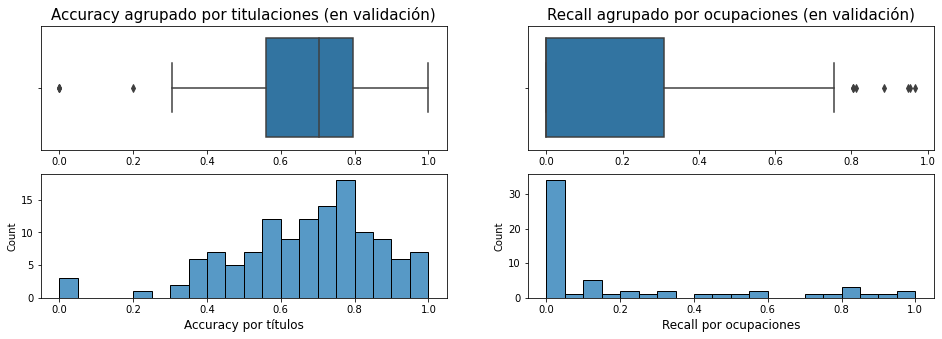

In [59]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2,figsize=(16,5))
font_titles=15
font_labels=12

sns.boxplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,x='accuracy regresor')
ax1.set_title('Accuracy agrupado por titulaciones (en validación)',fontsize=font_titles) 
ax1.set_xlabel('',fontsize=font_labels)

sns.boxplot(ax=ax2,data=naive_5_05_evalua_recall_vld,x='recall target')
ax2.set_title('Recall agrupado por ocupaciones (en validación)',fontsize=font_titles)
ax2.set_xlabel('',fontsize=font_labels)

sns.histplot(ax=ax3,data=naive_5_05_evalua_accuracy_vld,x='accuracy regresor',bins=np.arange(0,1.05,0.05))
#ax3.set_title('Accuracy agrupado por titulaciones (en validación)',fontsize=font_titles)
ax3.set_xlabel('Accuracy por títulos',fontsize=font_labels)

sns.histplot(ax=ax4,data=naive_5_05_evalua_recall_vld,x='recall target',bins=np.arange(0,1.05,0.05))
#ax4.set_title('Recall agrupado por ocupaciones (en validación)',fontsize=font_titles)
ax4.set_xlabel('Recall por ocupaciones',fontsize=font_labels)

fig.subplots_adjust(hspace=.2)
plt.show()

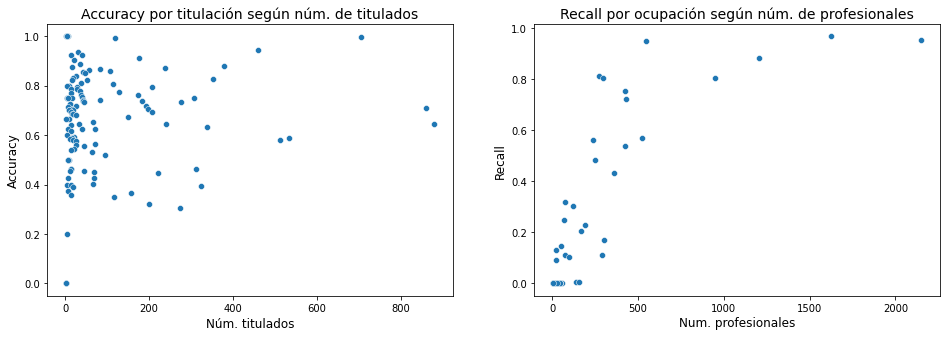

In [60]:
fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12

sns.scatterplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,x='num obs regresor',y='accuracy regresor')
ax1.set_title('Accuracy por titulación según núm. de titulados',fontsize=font_titles) 
ax1.set_xlabel('Núm. titulados',fontsize=font_labels)
ax1.set_ylabel('Accuracy',fontsize=font_labels)

sns.scatterplot(ax=ax2,data=naive_5_05_evalua_recall_vld,x='num obs target',y='recall target')
ax2.set_title('Recall por ocupación según núm. de profesionales',fontsize=font_titles)
ax2.set_xlabel('Num. profesionales',fontsize=font_labels)
ax2.set_ylabel('Recall',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [61]:
naive_5_05_evalua_accuracy_vld[['num obs regresor','accuracy regresor']].corr()

,num obs regresor,accuracy regresor
num obs regresor,1.000000,0.071733
accuracy regresor,0.071733,1.000000


In [62]:
naive_5_05_evalua_recall_vld[['num obs target','recall target']].corr()

,num obs target,recall target
num obs target,1.000000,0.796044
recall target,0.796044,1.000000


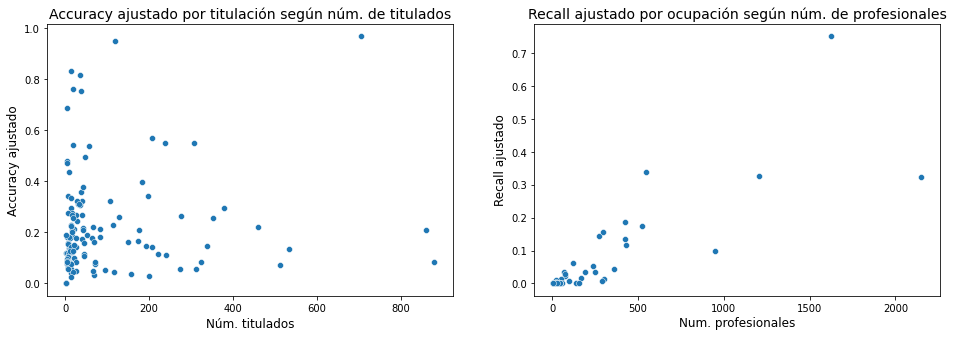

In [63]:
fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12


sns.scatterplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,x='num obs regresor',y='accuracy ajustado regresor')
ax1.set_title('Accuracy ajustado por titulación según núm. de titulados',fontsize=font_titles) 
ax1.set_xlabel('Núm. titulados',fontsize=font_labels)
ax1.set_ylabel('Accuracy ajustado',fontsize=font_labels)

sns.scatterplot(ax=ax2,data=naive_5_05_evalua_recall_vld,x='num obs target',y='recall ajustado target')
ax2.set_title('Recall ajustado por ocupación según núm. de profesionales',fontsize=font_titles)
ax2.set_xlabel('Num. profesionales',fontsize=font_labels)
ax2.set_ylabel('Recall ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [64]:
naive_5_05_evalua_accuracy_vld[['num obs regresor','accuracy ajustado regresor']].corr()

,num obs regresor,accuracy ajustado regresor
num obs regresor,1.000000,0.094353
accuracy ajustado regresor,0.094353,1.000000


In [65]:
naive_5_05_evalua_recall_vld[['num obs target','recall ajustado target']].corr()

,num obs target,recall ajustado target
num obs target,1.000000,0.840304
recall ajustado target,0.840304,1.000000


## Conclusiones

###### 1. El rendimiento evaluado por títulos (accuracy) es muy superior al recall evaluado por ocupaciones    

- El dataset es una **encuesta sobre titulados universitarios**: el muestreo está diseñado para garantizar una presencia representativa de los títulos universitarios, no de las ocupaciones profesionales. Los puestos de trabajo que no requieren formación universitaria están infrarepresentados respecto a su peso en la población general.  


###### 2. El accuracy para cada título es poco dependiente del número de egresados de la titulación     

###### 3. El recall por ocupaciones tiene una relación fuerte y directa con el número de profesionales encuestados  

- El **peor rendimiento** se da, sobre todo, en **ocupaciones que no requieren titulación universitaria**: las ocupaciones con **recall nulo** son profesiones no cualificadas u ocupaciones cuya formación especializada es no universitaria, con las excepciones de los profesionales en política y dirección de la Administración Pública y los profesionales de apoyo en finanzas y matemáticas. 
- Las ocupaciones con recall nulo son, también, las más infrarepresentadas en la encuesta. 

## Resúmenes de métricas de evaluación por titulaciones y  ocupaciones

In [66]:
def naive_evalua_criterio_resumen(clasificador,data,criterio):
    """ Función instrumental: generaliza el proceso de resumen de la evaluación de acuerdo con un 'criterio' 
    que se concretará como accuracy o como recall.
    """
    
    evalua_criterio=naive_evalua_agrega(clasificador=clasificador,data=data,criterio=criterio)
    evalua_resumen=evalua_criterio.agg(['sum','mean','median','min','argmin','max','argmax'])
    # Ajustes argmin y argmax: 
    for col in evalua_resumen.columns: 
        for arg in ['argmin','argmax']:
            indice_criterio=int(evalua_resumen.loc[arg,col])
            evalua_resumen.loc[arg,col]=evalua_criterio.index[indice_criterio]
    # Ajuste 'no aplica' (suma que no tiene sentido):
    #evalua_resumen.loc['sum','accuracy '+criterio]=''

    return evalua_resumen

In [67]:
def naive_evalua_accuracy_resumen(clasificador,data):
    
    evalua_resumen=naive_evalua_criterio_resumen(clasificador=clasificador,data=data,criterio='regresor')
    
    return evalua_resumen

In [68]:
def naive_evalua_recall_resumen(clasificador,data):
    
    evalua_resumen=naive_evalua_criterio_resumen(clasificador=clasificador,data=data,criterio='target')
    
    return evalua_resumen

In [69]:
naive_5_05_evalua_accuracy_resumen_vld=naive_evalua_accuracy_resumen(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_accuracy_resumen_vld

,aciertos por cat regresor,aciertos ajustados por cat regresor,num obs regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor
sum,8263,3023.09,11969,85.2566,28.4022,1,0.690367,0.252577
mean,64.5547,23.6179,93.5078,0.666067,0.221892,0.0078125,0.00539349,0.00197325
median,18.5,4.85256,25,0.702792,0.163395,0.00208873,0.00154566,0.000405427
min,0,0,1,0,0,8.35492e-05,0,0
argmin,Máster Silvicultura,Máster Silvicultura,Máster Religión y teología,Máster Silvicultura,Máster Silvicultura,Máster Religión y teología,Máster Silvicultura,Máster Silvicultura
max,702,681.778,880,1,0.968434,0.0735233,0.0586515,0.056962
argmax,Grado Medicina,Grado Medicina,Grado Administración y empresa,Máster Ingeniería y procesos químicos,Grado Medicina,Grado Administración y empresa,Grado Medicina,Grado Medicina


In [70]:
naive_5_05_evalua_recall_resumen_vld=naive_evalua_recall_resumen(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_recall_resumen_vld

,aciertos por cat target,aciertos ajustados por cat target,num obs target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
sum,8263,3023.09,11969,12.4142,3.14299,1,0.690367,0.252577
mean,137.717,50.3848,199.483,0.206904,0.0523831,0.0166667,0.0115061,0.00420961
median,0,0,41,0,0,0.00342552,0,0
min,0,0,1,0,0,8.35492e-05,0,0
argmin,Gerentes hostelería y comercio,Gerentes hostelería y comercio,Trabajadores construcción e instalaciones: acabado,Gerentes hostelería y comercio,Gerentes hostelería y comercio,Trabajadores construcción e instalaciones: acabado,Gerentes hostelería y comercio,Gerentes hostelería y comercio
max,2049,1219.24,2152,0.967344,0.751225,0.179798,0.171192,0.101866
argmax,"Prof ciencias, matemáticas e ingeniería",Prof sanitarios,"Prof ciencias, matemáticas e ingeniería",Prof sanitarios,Prof sanitarios,"Prof ciencias, matemáticas e ingeniería","Prof ciencias, matemáticas e ingeniería",Prof sanitarios
